# XLA in Python

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/XLA_in_Python.ipynb)

<img style="height:100px;" src="https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/compiler/xla/g3doc/images/xlalogo.png"> <img style="height:100px;" src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg">

_Anselm Levskaya_, _Qiao Zhang_

XLA is the compiler that JAX uses, and the compiler that TF uses for TPUs and will soon use for all devices, so it's worth some study.  However, it's not exactly easy to play with XLA computations directly using the raw C++ interface.  JAX exposes the underlying XLA computation builder API through a python wrapper, and makes interacting with the XLA compute model accessible for messing around and prototyping.

XLA computations are built as computation graphs in HLO IR, which is then lowered to LLO that is device specific (CPU, GPU, TPU, etc.).  

As end users we interact with the computational primitives offered to us by the HLO spec.

**Caution:  This is a pedagogical notebook covering some low level XLA details, the APIs herein are neither public nor stable!**

## References 

__xla__: the doc that defines what's in HLO - but note that the doc is incomplete and omits some ops.

https://www.tensorflow.org/xla/operation_semantics

more details on ops in the source code.

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/client/xla_builder.h

__python xla client__:  this is the XLA python client for JAX, and what we're using here.

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/python/xla_client.py

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/python/xla_client_test.py

__jax__: you can see how jax interacts with the XLA compute layer for execution and JITing in these files.

https://github.com/google/jax/blob/master/jax/lax.py

https://github.com/google/jax/blob/master/jax/lib/xla_bridge.py

https://github.com/google/jax/blob/master/jax/interpreters/xla.py

## Colab Setup and Imports

In [1]:
import numpy as np

# We only need to import JAX's xla_client, not all of JAX.
from jax.lib import xla_client as xc
xops = xc.ops

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False

## Simple Computations

In [2]:
# make a computation builder
c = xc.XlaBuilder("simple_scalar")

# define a parameter shape and parameter
param_shape = xc.Shape.array_shape(np.dtype(np.float32), ())
x = xops.Parameter(c, 0, param_shape)

# define computation graph
y = xops.Sin(x)

# build computation graph
# Keep in mind that incorrectly constructed graphs can cause 
# your notebook kernel to crash!
computation = c.Build()

# get a cpu backend
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(computation)

# define a host variable with above parameter shape
host_input = np.array(3.0, dtype=np.float32)

# place host variable on device and execute
device_input = cpu_backend.buffer_from_pyval(host_input)
device_out = compiled_computation.execute([device_input ,])

# retrive the result
device_out[0].to_py()

array(0.14112, dtype=float32)

In [3]:
# same as above with vector type:

c = xc.XlaBuilder("simple_vector")
param_shape = xc.Shape.array_shape(np.dtype(np.float32), (3,))
x = xops.Parameter(c, 0, param_shape)

# chain steps by reference:
y = xops.Sin(x)
z = xops.Abs(y)
computation = c.Build()

# get a cpu backend
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(computation)

host_input = np.array([3.0, 4.0, 5.0], dtype=np.float32)

device_input = cpu_backend.buffer_from_pyval(host_input)
device_out = compiled_computation.execute([device_input ,])

# retrive the result
device_out[0].to_py()

array([0.14112  , 0.7568025, 0.9589243], dtype=float32)

## Simple While Loop

In [4]:
# trivial while loop, decrement until 0
#   x = 5
#   while x > 0:
#     x = x - 1
#
in_shape = xc.Shape.array_shape(np.dtype(np.int32), ())

# body computation:
bcb = xc.XlaBuilder("bodycomp")
x = xops.Parameter(bcb, 0, in_shape)
const1 = xops.Constant(bcb, np.int32(1))
y = xops.Sub(x, const1)
body_computation = bcb.Build()

# test computation:
tcb = xc.XlaBuilder("testcomp")
x = xops.Parameter(tcb, 0, in_shape)
const0 = xops.Constant(tcb, np.int32(0))
y = xops.Gt(x, const0)
test_computation = tcb.Build()

# while computation:
wcb = xc.XlaBuilder("whilecomp")
x = xops.Parameter(wcb, 0, in_shape)
xops.While(test_computation, body_computation, x)
while_computation = wcb.Build()

# Now compile and execute:
# get a cpu backend
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(while_computation)

host_input = np.array(5, dtype=np.int32)

device_input = cpu_backend.buffer_from_pyval(host_input)
device_out = compiled_computation.execute([device_input ,])

# retrive the result
device_out[0].to_py()

array(0, dtype=int32)

## While loops w/ Tuples - Newton's Method for sqrt

In [5]:
Xsqr = 2
guess = 1.0
converged_delta = 0.001
maxit = 1000

in_shape_0 = xc.Shape.array_shape(np.dtype(np.float32), ())
in_shape_1 = xc.Shape.array_shape(np.dtype(np.float32), ())
in_shape_2 = xc.Shape.array_shape(np.dtype(np.int32), ())
in_tuple_shape = xc.Shape.tuple_shape([in_shape_0, in_shape_1, in_shape_2])

# body computation:
# x_{i+1} = x_i - (x_i**2 - y) / (2 * x_i)
bcb = xc.XlaBuilder("bodycomp")
intuple = xops.Parameter(bcb, 0, in_tuple_shape)
y = xops.GetTupleElement(intuple, 0)
x = xops.GetTupleElement(intuple, 1)
guard_cntr = xops.GetTupleElement(intuple, 2)
new_x = xops.Sub(x, xops.Div(xops.Sub(xops.Mul(x, x), y), xops.Add(x, x)))
result = xops.Tuple(bcb, [y, new_x, xops.Sub(guard_cntr, xops.Constant(bcb, np.int32(1)))])
body_computation = bcb.Build()

# test computation -- convergence and max iteration test
tcb = xc.XlaBuilder("testcomp")
intuple = xops.Parameter(tcb, 0, in_tuple_shape)
y = xops.GetTupleElement(intuple, 0)
x = xops.GetTupleElement(intuple, 1)
guard_cntr = xops.GetTupleElement(intuple, 2)
criterion = xops.Abs(xops.Sub(xops.Mul(x, x), y))
# stop at convergence criteria or too many iterations
test = xops.And(xops.Gt(criterion, xops.Constant(tcb, np.float32(converged_delta))), 
               xops.Gt(guard_cntr, xops.Constant(tcb, np.int32(0))))
test_computation = tcb.Build()

# while computation:
# since jax does not allow users to create a tuple input directly, we need to
# take multiple parameters and make a intermediate tuple before feeding it as
# an initial carry to while loop
wcb = xc.XlaBuilder("whilecomp")
y = xops.Parameter(wcb, 0, in_shape_0)
x = xops.Parameter(wcb, 1, in_shape_1)
guard_cntr = xops.Parameter(wcb, 2, in_shape_2)
tuple_init_carry = xops.Tuple(wcb, [y, x, guard_cntr])
xops.While(test_computation, body_computation, tuple_init_carry)
while_computation = wcb.Build()

# Now compile and execute:
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(while_computation)

y = np.array(Xsqr, dtype=np.float32)
x = np.array(guess, dtype=np.float32)
maxit = np.array(maxit, dtype=np.int32)

device_input_y = cpu_backend.buffer_from_pyval(y)
device_input_x = cpu_backend.buffer_from_pyval(x)
device_input_maxit = cpu_backend.buffer_from_pyval(maxit)
device_out = compiled_computation.execute([device_input_y, device_input_x, device_input_maxit])

# retrive the result
print("square root of {y} is {x}".format(y=y, x=device_out[1].to_py()))

square root of 2.0 is 1.4142156839370728


## Calculate Symm Eigenvalues

Let's exploit the XLA QR implementation to solve some eigenvalues for symmetric matrices.  

This is the naive QR algorithm, without acceleration for closely-spaced eigenvalue convergence, nor any permutation to sort eigenvalues by magnitude.

sorted eigenvalues
[-1.1406534  -0.5946617  -0.29557052 -0.09876542  0.07503236  0.19509281
  0.47496718  0.858686    1.09709     5.281351  ]
sorted eigenvalues from numpy
[-1.140657   -0.5946614  -0.29557055 -0.09876533  0.07503222  0.19509293
  0.47496703  0.85868585  1.0970895   5.2813535 ]
sorted error
[ 3.5762787e-06 -2.9802322e-07  2.9802322e-08 -8.9406967e-08
  1.4156103e-07 -1.1920929e-07  1.4901161e-07  1.1920929e-07
  4.7683716e-07 -2.3841858e-06]


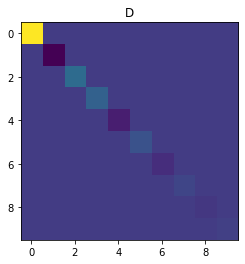

In [6]:
Niter = 200
matrix_shape = (10, 10)

in_shape_0 = xc.Shape.array_shape(np.dtype(np.float32), matrix_shape)
in_shape_1 = xc.Shape.array_shape(np.dtype(np.int32), ())
in_tuple_shape = xc.Shape.tuple_shape([in_shape_0, in_shape_1])

# body computation -- QR loop: X_i = Q R , X_{i+1} = R Q

bcb = xc.XlaBuilder("bodycomp")
intuple = xops.Parameter(bcb, 0, in_tuple_shape)
x = xops.GetTupleElement(intuple, 0)
cntr = xops.GetTupleElement(intuple, 1)
Q, R = xops.QR(x, True)
RQ = xops.Dot(R, Q)
xops.Tuple(bcb, [RQ, xops.Sub(cntr, xops.Constant(bcb, np.int32(1)))])
body_computation = bcb.Build()

# test computation -- just a for loop condition
tcb = xc.XlaBuilder("testcomp")
intuple = xops.Parameter(tcb, 0, in_tuple_shape)
cntr = xops.GetTupleElement(intuple, 1)
test = xops.Gt(cntr, xops.Constant(tcb, np.int32(0)))
test_computation = tcb.Build()

# while computation:
wcb = xc.XlaBuilder("whilecomp")
x = xops.Parameter(wcb, 0, in_shape_0)
cntr = xops.Parameter(wcb, 1, in_shape_1)
tuple_init_carry = xops.Tuple(wcb, [x, cntr])
xops.While(test_computation, body_computation, tuple_init_carry)
while_computation = wcb.Build()

# Now compile and execute:
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(while_computation)

X = np.random.random(matrix_shape).astype(np.float32)
X = (X + X.T) / 2.0
it = np.array(Niter, dtype=np.int32)

device_input_x = cpu_backend.buffer_from_pyval(X)
device_input_it = cpu_backend.buffer_from_pyval(it)
device_out = compiled_computation.execute([device_input_x, device_input_it])

host_out = device_out[0].to_py()
eigh_vals = host_out.diagonal()

plt.title('D')
plt.imshow(host_out)
print('sorted eigenvalues')
print(np.sort(eigh_vals))
print('sorted eigenvalues from numpy')
print(np.sort(np.linalg.eigh(X)[0]))
print('sorted error') 
print(np.sort(eigh_vals) - np.sort(np.linalg.eigh(X)[0]))

## Calculate Full Symm Eigensystem

We can also calculate the  eigenbasis by accumulating the Qs.

sorted eigenvalues
[-0.95164776 -0.5988633  -0.28330874 -0.07402738  0.15438193  0.19796501
  0.4779069   0.58893895  0.81445134  4.5762177 ]
sorted eigenvalues from numpy
[-0.95164794 -0.6314303  -0.28330857 -0.07402731  0.15438198  0.19796519
  0.47790694  0.62150407  0.81445104  4.5762167 ]
sorted error
[ 1.7881393e-07  3.2567024e-02 -1.7881393e-07 -6.7055225e-08
 -4.4703484e-08 -1.7881393e-07 -2.9802322e-08 -3.2565117e-02
  2.9802322e-07  9.5367432e-07]


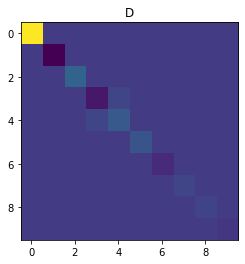

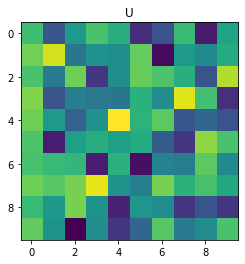

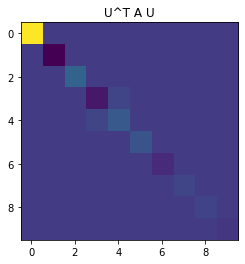

In [7]:
Niter = 100
matrix_shape = (10, 10)

in_shape_0 = xc.Shape.array_shape(np.dtype(np.float32), matrix_shape)
in_shape_1 = xc.Shape.array_shape(np.dtype(np.float32), matrix_shape)
in_shape_2 = xc.Shape.array_shape(np.dtype(np.int32), ())
in_tuple_shape = xc.Shape.tuple_shape([in_shape_0, in_shape_1, in_shape_2])

# body computation -- QR loop: X_i = Q R , X_{i+1} = R Q
bcb = xc.XlaBuilder("bodycomp")
intuple = xops.Parameter(bcb, 0, in_tuple_shape)
X = xops.GetTupleElement(intuple, 0)
O = xops.GetTupleElement(intuple, 1)
cntr = xops.GetTupleElement(intuple, 2)
Q, R = xops.QR(X, True)
RQ = xops.Dot(R, Q)
Onew = xops.Dot(O, Q)
xops.Tuple(bcb, [RQ, Onew, xops.Sub(cntr, xops.Constant(bcb, np.int32(1)))])
body_computation = bcb.Build()

# test computation -- just a for loop condition
tcb = xc.XlaBuilder("testcomp")
intuple = xops.Parameter(tcb, 0, in_tuple_shape)
cntr = xops.GetTupleElement(intuple, 2)
test = xops.Gt(cntr, xops.Constant(tcb, np.int32(0)))
test_computation = tcb.Build()

# while computation:
wcb = xc.XlaBuilder("whilecomp")
X = xops.Parameter(wcb, 0, in_shape_0)
O = xops.Parameter(wcb, 1, in_shape_1)
cntr = xops.Parameter(wcb, 2, in_shape_2)
tuple_init_carry = xops.Tuple(wcb, [X, O, cntr])
xops.While(test_computation, body_computation, tuple_init_carry)
while_computation = wcb.Build()

# Now compile and execute:
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(while_computation)

X = np.random.random(matrix_shape).astype(np.float32)
X = (X + X.T) / 2.0
Omat = np.eye(matrix_shape[0], dtype=np.float32)
it = np.array(Niter, dtype=np.int32)

device_input_X = cpu_backend.buffer_from_pyval(X)
device_input_Omat = cpu_backend.buffer_from_pyval(Omat)
device_input_it = cpu_backend.buffer_from_pyval(it)
device_out = compiled_computation.execute([device_input_X, device_input_Omat, device_input_it])

host_out = device_out[0].to_py()
eigh_vals = host_out.diagonal()
eigh_mat = device_out[1].to_py()

plt.title('D')
plt.imshow(host_out)
plt.figure()
plt.title('U')
plt.imshow(eigh_mat)
plt.figure()
plt.title('U^T A U')
plt.imshow(np.dot(np.dot(eigh_mat.T, X), eigh_mat))
print('sorted eigenvalues')
print(np.sort(eigh_vals))
print('sorted eigenvalues from numpy')
print(np.sort(np.linalg.eigh(X)[0]))
print('sorted error') 
print(np.sort(eigh_vals) - np.sort(np.linalg.eigh(X)[0]))

## Convolutions

I keep hearing from the AGI folks that we can use convolutions to build artificial life.  Let's try it out.

In [8]:
# Here we borrow convenience functions from LAX to handle conv dimension numbers.
from typing import NamedTuple, Sequence

class ConvDimensionNumbers(NamedTuple):
  """Describes batch, spatial, and feature dimensions of a convolution.

  Args:
    lhs_spec: a tuple of nonnegative integer dimension numbers containing
      `(batch dimension, feature dimension, spatial dimensions...)`.
    rhs_spec: a tuple of nonnegative integer dimension numbers containing
      `(out feature dimension, in feature dimension, spatial dimensions...)`.
    out_spec: a tuple of nonnegative integer dimension numbers containing
      `(batch dimension, feature dimension, spatial dimensions...)`.
  """
  lhs_spec: Sequence[int]
  rhs_spec: Sequence[int]
  out_spec: Sequence[int]

def _conv_general_proto(dimension_numbers):
  assert type(dimension_numbers) is ConvDimensionNumbers
  lhs_spec, rhs_spec, out_spec = dimension_numbers
  proto = xc.ConvolutionDimensionNumbers()
  proto.input_batch_dimension = lhs_spec[0]
  proto.input_feature_dimension = lhs_spec[1]
  proto.output_batch_dimension = out_spec[0]
  proto.output_feature_dimension = out_spec[1]
  proto.kernel_output_feature_dimension = rhs_spec[0]
  proto.kernel_input_feature_dimension = rhs_spec[1]
  proto.input_spatial_dimensions.extend(lhs_spec[2:])
  proto.kernel_spatial_dimensions.extend(rhs_spec[2:])
  proto.output_spatial_dimensions.extend(out_spec[2:])
  return proto

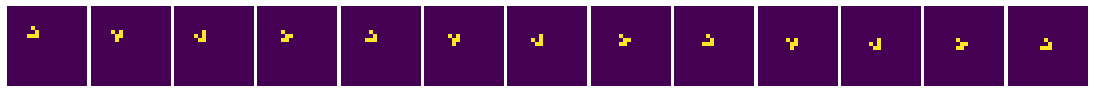

In [9]:
Niter=13
matrix_shape = (1, 1, 20, 20)
in_shape_0 = xc.Shape.array_shape(np.dtype(np.int32), matrix_shape)
in_shape_1 = xc.Shape.array_shape(np.dtype(np.int32), ())
in_tuple_shape = xc.Shape.tuple_shape([in_shape_0, in_shape_1])

# Body computation -- Conway Update
bcb = xc.XlaBuilder("bodycomp")
intuple = xops.Parameter(bcb, 0, in_tuple_shape)
x = xops.GetTupleElement(intuple, 0)
cntr = xops.GetTupleElement(intuple, 1)
# convs require floating-point type
xf = xops.ConvertElementType(x, xc.DTYPE_TO_XLA_ELEMENT_TYPE['float32'])
stamp = xops.Constant(bcb, np.ones((1,1,3,3), dtype=np.float32))
conv_dim_num_proto = _conv_general_proto(ConvDimensionNumbers(lhs_spec=(0,1,2,3), rhs_spec=(0,1,2,3), out_spec=(0,1,2,3)))
convd = xops.ConvGeneralDilated(xf, stamp, [1, 1], [(1, 1), (1, 1)], (), (), conv_dim_num_proto)
# # logic ops require integer types
convd = xops.ConvertElementType(convd, xc.DTYPE_TO_XLA_ELEMENT_TYPE['int32'])
bool_x = xops.Eq(x, xops.Constant(bcb, np.int32(1)))
# core update rule
res = xops.Or(
    # birth rule
    xops.And(xops.Not(bool_x), xops.Eq(convd, xops.Constant(bcb, np.int32(3)))),
    # survival rule
    xops.And(bool_x, xops.Or(
        # these are +1 the normal numbers since conv-sum counts self
        xops.Eq(convd, xops.Constant(bcb, np.int32(4))),
        xops.Eq(convd, xops.Constant(bcb, np.int32(3))))
    )
)
# Convert output back to int type for type constancy
int_res = xops.ConvertElementType(res, xc.DTYPE_TO_XLA_ELEMENT_TYPE['int32'])
xops.Tuple(bcb, [int_res, xops.Sub(cntr, xops.Constant(bcb, np.int32(1)))])
body_computation = bcb.Build()

# Test computation -- just a for loop condition
tcb = xc.XlaBuilder("testcomp")
intuple = xops.Parameter(tcb, 0, in_tuple_shape)
cntr = xops.GetTupleElement(intuple, 1)
test = xops.Gt(cntr, xops.Constant(tcb, np.int32(0)))
test_computation = tcb.Build()

# While computation:
wcb = xc.XlaBuilder("whilecomp")
x = xops.Parameter(wcb, 0, in_shape_0)
cntr = xops.Parameter(wcb, 1, in_shape_1)
tuple_init_carry = xops.Tuple(wcb, [x, cntr])
xops.While(test_computation, body_computation, tuple_init_carry)
while_computation = wcb.Build()

# Now compile and execute:
cpu_backend = xc.get_local_backend("cpu")

# compile graph based on shape
compiled_computation = cpu_backend.compile(while_computation)

# Set up initial state
X = np.zeros(matrix_shape, dtype=np.int32)
X[0,0, 5:8, 5:8] = np.array([[0,1,0],[0,0,1],[1,1,1]])

# Evolve
movie = np.zeros((Niter,)+matrix_shape[-2:], dtype=np.int32)
for it in range(Niter):
  itr = np.array(it, dtype=np.int32)
  device_input_x = cpu_backend.buffer_from_pyval(X)
  device_input_it = cpu_backend.buffer_from_pyval(itr)
  device_out = compiled_computation.execute([device_input_x, device_input_it])
  movie[it] = device_out[0].to_py()[0,0]

# Plot
fig = plt.figure(figsize=(15,2))
gs = gridspec.GridSpec(1,Niter)
for i in range(Niter):
  ax1 = plt.subplot(gs[:, i])
  ax1.axis('off')
  ax1.imshow(movie[i])
plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, hspace=0.0, wspace=0.05)

## Fin 

There's much more to XLA, but this hopefully highlights how easy it is to play with via the python client!